# Dynamic Linear Regression

In [1]:
import os
import sys
import pandas as pd
import tensorflow as tf
from plotnine import geom_line, aes

sys.path.append(os.path.relpath('../dynamic_regression/'))
sys.path.append(os.path.relpath('../aux/'))

from data_regression_simulator import get_dynamic_regression_simulated_data
from dynamic_regression import DynamicRegression
from dynamic_regression_plotter import DynamicRegressionPlotter

Suppose we have a variable of interest $Y$, indexed in time, as well as time series of $m$ features, $x_t$.

We start by fitting a linear regression model, $Y_t = x'_t \beta + \epsilon_t$, with i.i.d. Normal error $\epsilon_t$.

The model fit looks fair, but upon closer inspection of the residuals we notice that they have some temporal structure. Perhaps we are missing an important feature. However, in this notebook we explore another possibility: what if the regression coefficients $\beta$ actually change over time?

Under this hypothesis, we build the following Dynamic Linear Regression model:

$$Y_t = x'_t \mu_t + \epsilon_t, $$

$$\mu_t = \mu_{t-1} + \nu_t, $$

$$\epsilon_t \sim N[0, 1 / \sigma^2], $$

$$\nu_t \sim N[0, 1 / \tau^2 I], $$

$$\mu_0 \sim N[0, I], $$

$$\sigma^2 \sim G[a_0, b_0], $$

$$\tau^2 \sim G[g_0, h_0], $$

where
- we we place $m$, preferably standardized features in the $m\times 1$ vector $x_t$;
- the observation error $\epsilon_t$ is i.i.d. Normal (as before);
- the $m$ regression coefficients $\mu_t$ evolve as a random walk;
- the $m$ random walk shocks $\nu_t$ are i.i.d. Normal;
- before observing any data, we assume the regression coefficients are i.i.d. Normal with mean 0 and variance 1.

To fit this model, we are going to:
- simulate data where the regression coefficients follow a sinusoidal pattern;
- create two objects of classes DynamicRegression and DynamicRegressionPlotter, designed with TFP for this purpose;
- obtain Maximum A Posteriori estimates for parameters $\sigma^2$ and $\tau^2$;
- sample the latent state $\mu_t$ given the MAP estimates and compare model predictions to observations;
- obtain Variational Bayes approximate distributions for $\sigma^2$ and $\tau^2$;
- sample $\mu_t$ given the VB samples of $\sigma^2$ and $\tau^2$ and compare model predictions to observations;

In [2]:
# getting simulated data
df, coeff_df = get_dynamic_regression_simulated_data(num_instants=12*30, num_features=2)
# melting coeff_df (the table of true regression coefficients) for later plotting with plotnine
coeff_df = pd.melt(coeff_df, id_vars=['time'], value_vars=[x for x in coeff_df if x not in ['time']])
true_coeff_lines = geom_line(aes(x="time", y="value", group="variable", color="variable"), data=coeff_df)
# this is the simulated dataset
df

,time,response,feature_0,feature_1
0,1951-01-01,2.934512,1.764052,0.400157
1,1951-02-01,-0.528795,0.978738,2.240893
2,1951-03-01,4.795757,1.867558,-0.977278
3,1951-04-01,1.856727,0.950088,-0.151357
4,1951-05-01,-1.410773,-0.103219,0.410599
...,...,...,...,...
355,1980-08-01,-0.251088,-0.704921,0.679975
356,1980-09-01,-0.404879,-0.696327,-0.290397
357,1980-10-01,0.821086,1.327783,-0.101281
358,1980-11-01,-1.240264,-0.803141,-0.464338


## Set up

In [3]:
# Initializing objects and listing methods.
dr = DynamicRegression()
pl = DynamicRegressionPlotter(model=dr)
dr.methods()

['fit_map',
 'fit_vb',
 'get_diagnostics',
 'get_forecast_residuals',
 'get_mu_distribution',
 'get_one_step_forecast_moments',
 'get_posterior_predictive_distribution',
 'get_sample_from_prior',
 'get_simulated_data',
 'get_smoothed_mu_moments',
 'get_vb_parameter_sample',
 'set_metadata',
 'set_model',
 'set_options']

In [4]:
# Priors and random seed
dr.set_options({"sigma2_mean": 1,
                "sigma2_var": 1,
                "tau2_mean": 1, 
                "tau2_var": 1,
                "latent_process_initial_scale": 1,
                "object_seed": 1})

# Loading the input dataframe
dr.set_model(df=df,
             response_name='response',
             time_name='time',
             features_names=[x for x in df.columns if x not in ['time', 'response']])

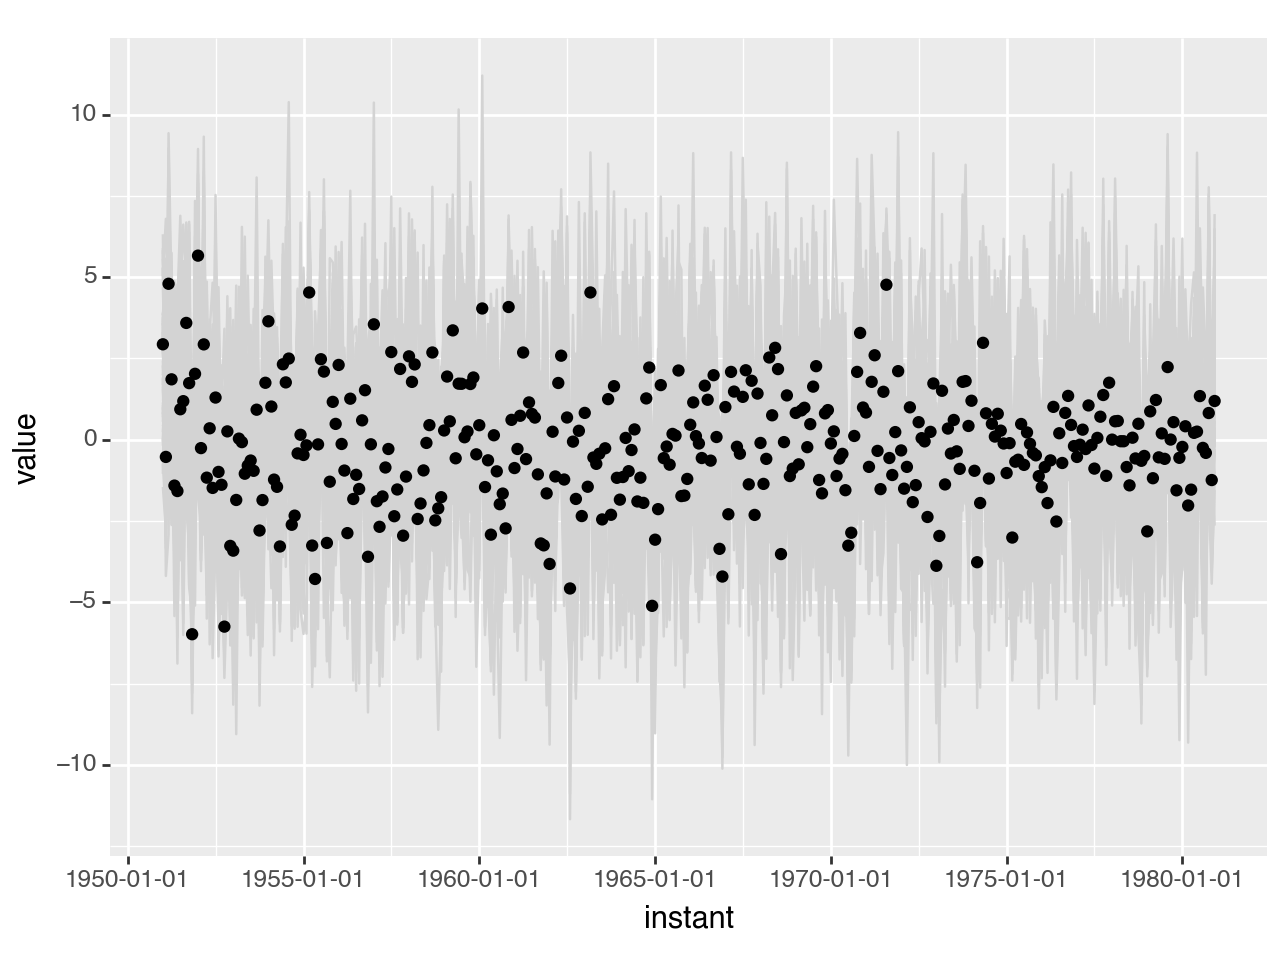

<Figure Size: (640 x 480)>

In [5]:
# Let's plot the data (black dots) together with samples from the DLR model, 
# based on a small value for \sigma^2 and a high value for \tau^2. 
# The latter choice causes the DLR model to resemble the standard linear regression model.

sigma2, tau2, _ = dr.get_sample_from_prior()
params = {'sigma2': 0.1 * sigma2, 'tau2': 1e6 * tau2}

pl.timeseries_obs_vs_fit(lines=False, points=True, params=params, num_model_samples=60)

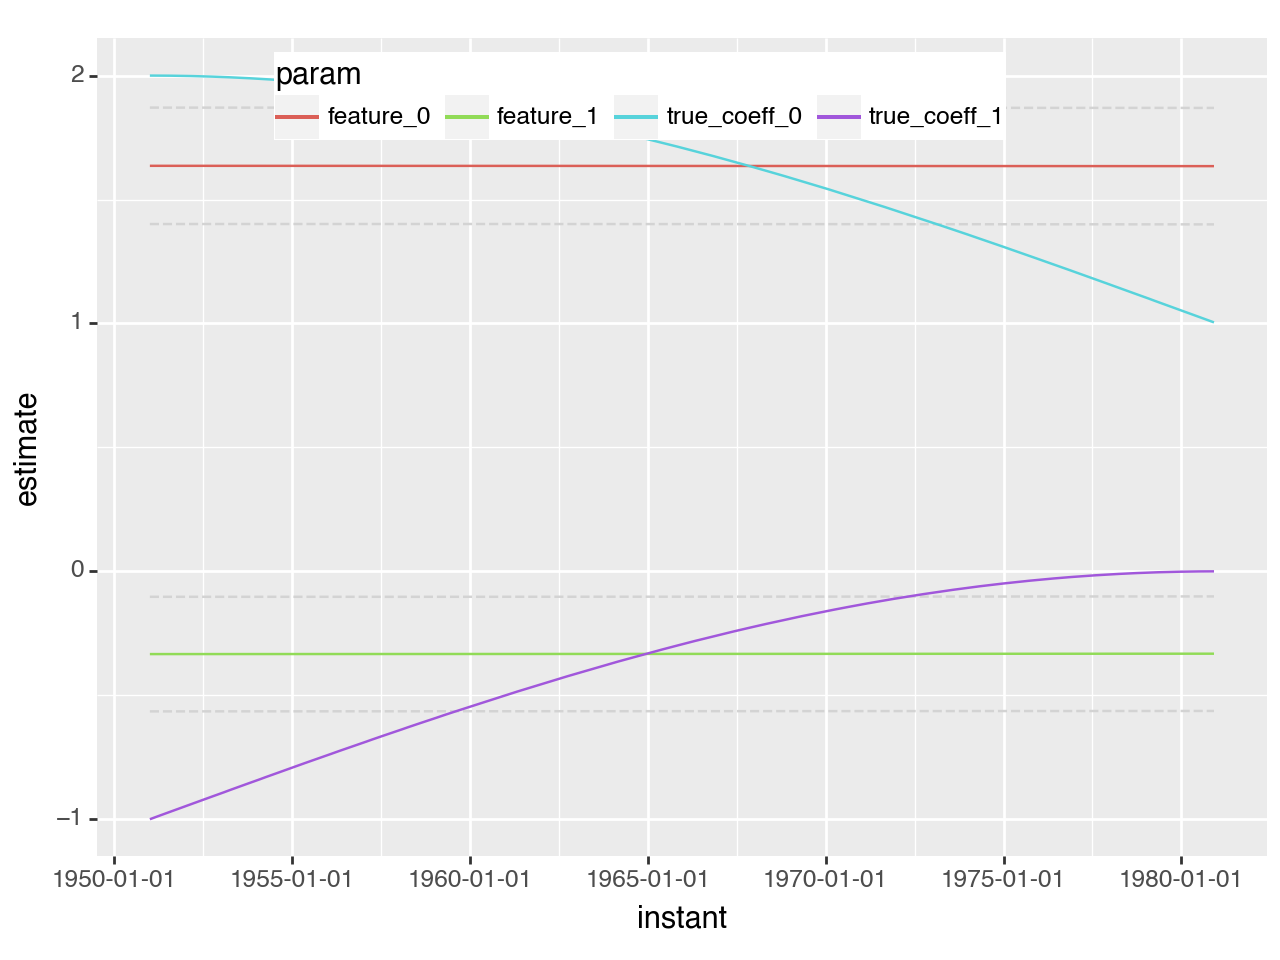

<Figure Size: (640 x 480)>

In [6]:
# Next we plot the estimated means +/- 2 sds for the regression coefficients (red and green), 
# along with the true coefficient lines (blue and purple). 
# Given the high value of $\tau^2$, the coefficients appear time-invariant. 
# Also, they approximate the long-term mean value of the true coefficients.

pl.timeseries_regression_coeffs(params=params) + true_coeff_lines

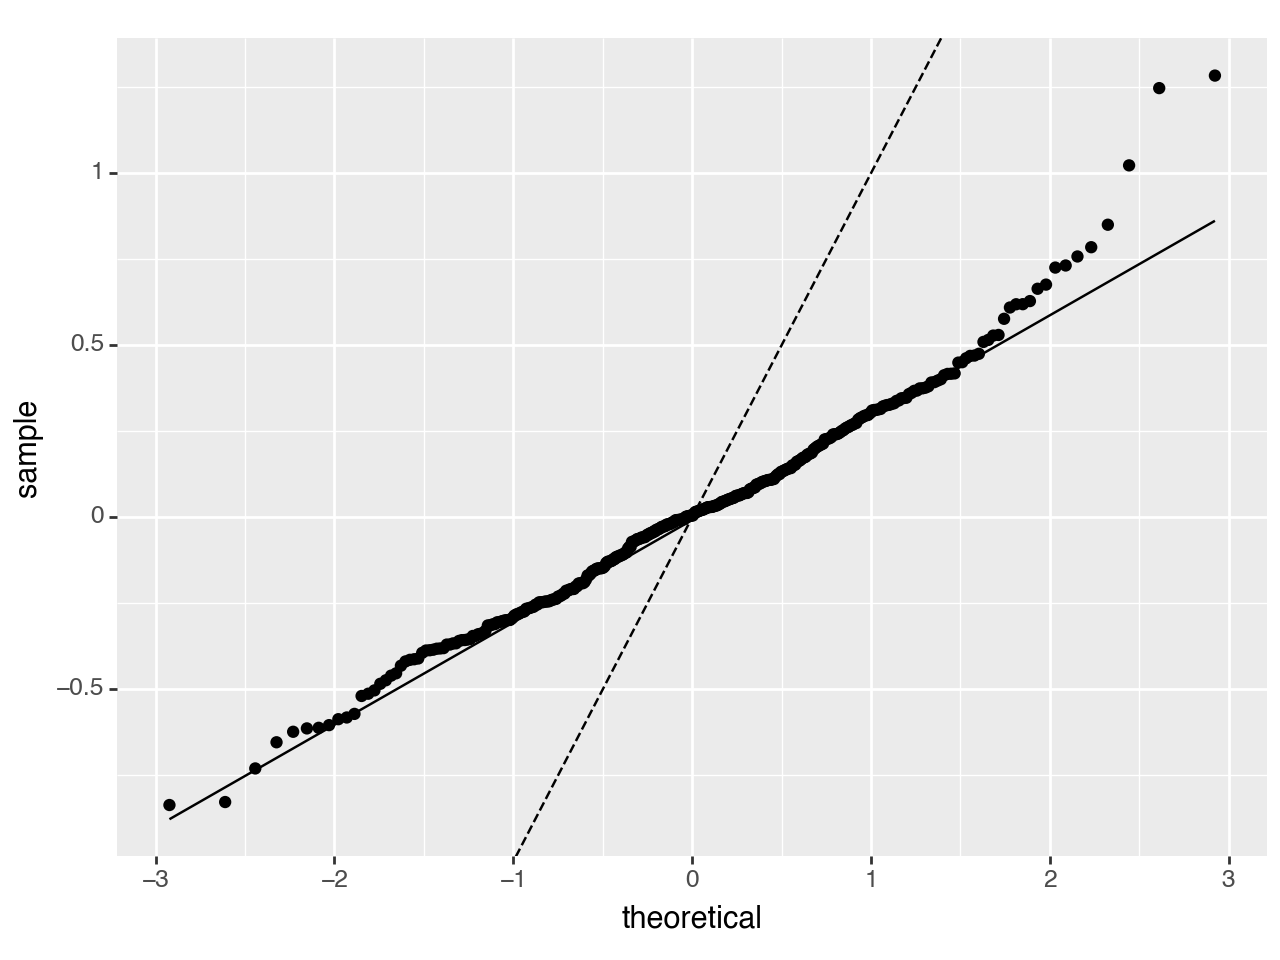

<Figure Size: (640 x 480)>

In [7]:
# The following qq-plot shows that the model with time-invariant regression coefficients yields a poor fit, 
# because standardized residuals strongly deviate from the expected Normal(0,1) distribution.

pl.forecast_residuals_qqplot(params=params)

## Maximum A Posterior estimation

Let us now get MAP estimates.

In [8]:
map_params, map_losses = dr.fit_map(
    learning_rate=0.5,
    num_steps=1000,
    jit_compile=False)
map_params

{'sigma2': <TransformedVariable: name=map_sigma2, dtype=float32, shape=[], fn="softplus", numpy=5.3279486>,
 'tau2': <TransformedVariable: name=map_tau2, dtype=float32, shape=[], fn="softplus", numpy=30.933931>}

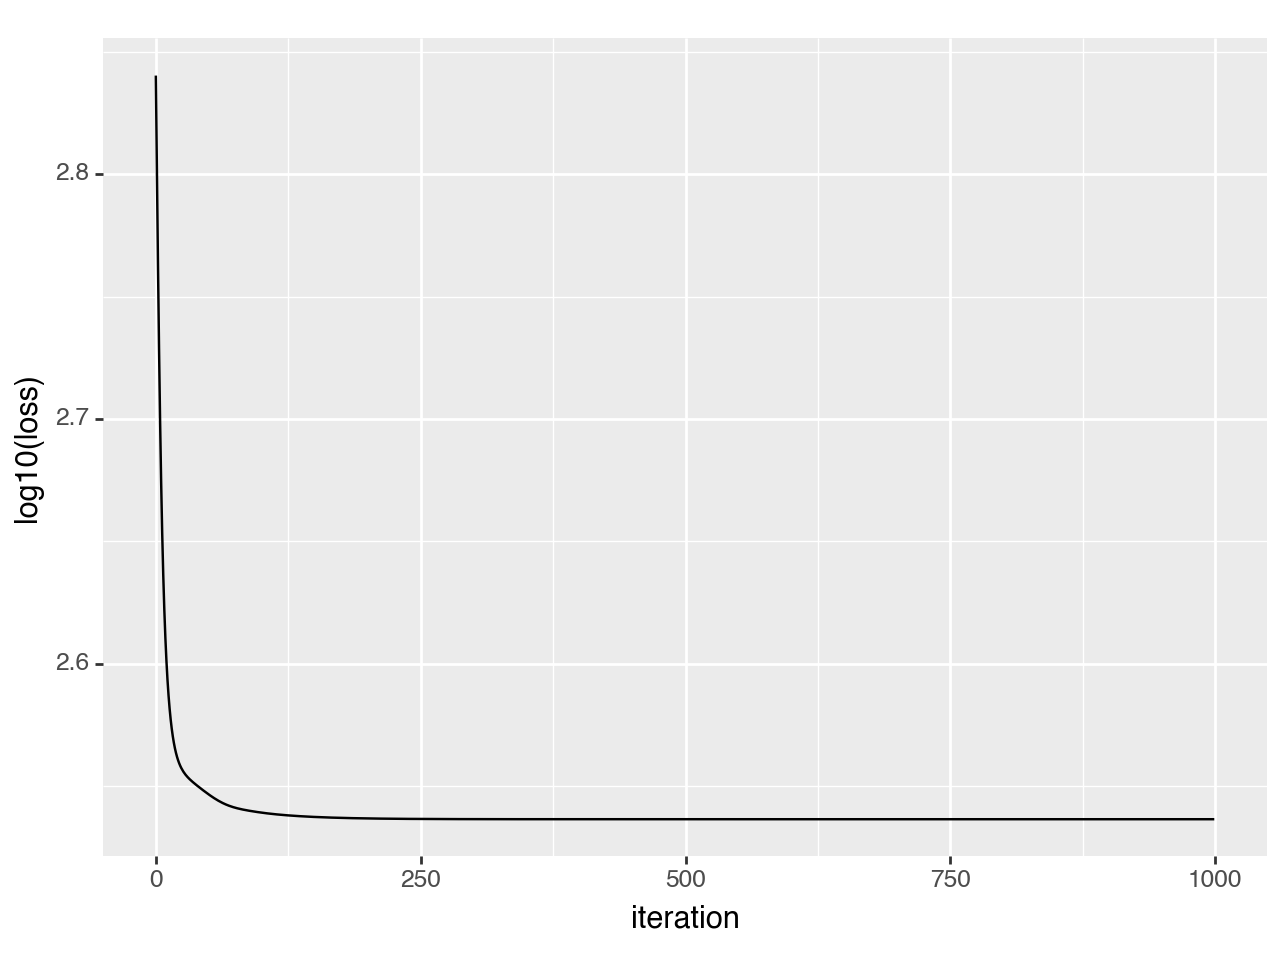

<Figure Size: (640 x 480)>

In [9]:
# plot the loss of this model fit, to assess convergence
pl.losses(map_losses)

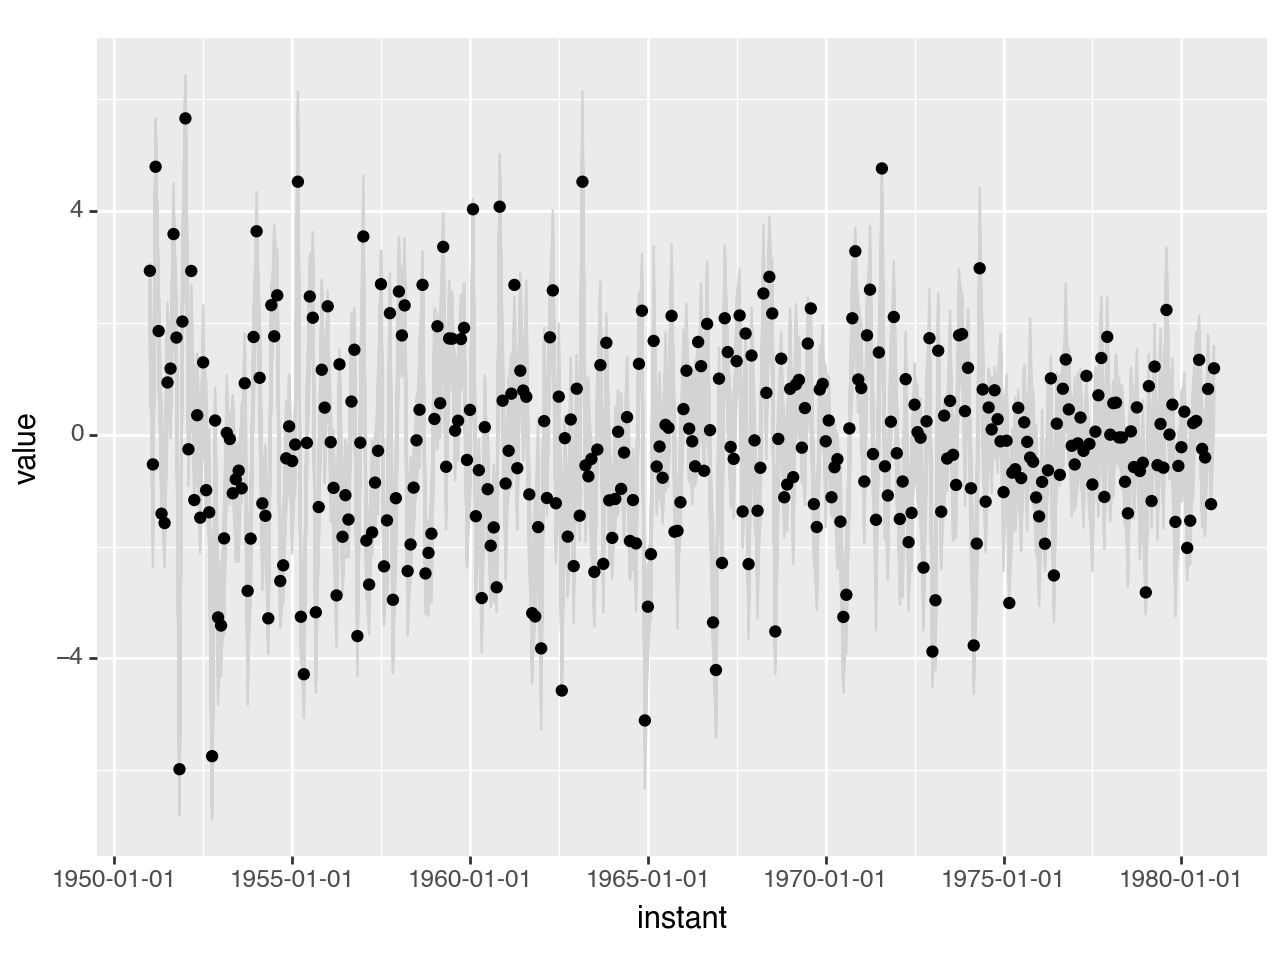

<Figure Size: (640 x 480)>

In [10]:
# plot the new time series of fitted values vs obs
pl.timeseries_obs_vs_fit(lines=False, points=True, params=map_params, num_model_samples=60)

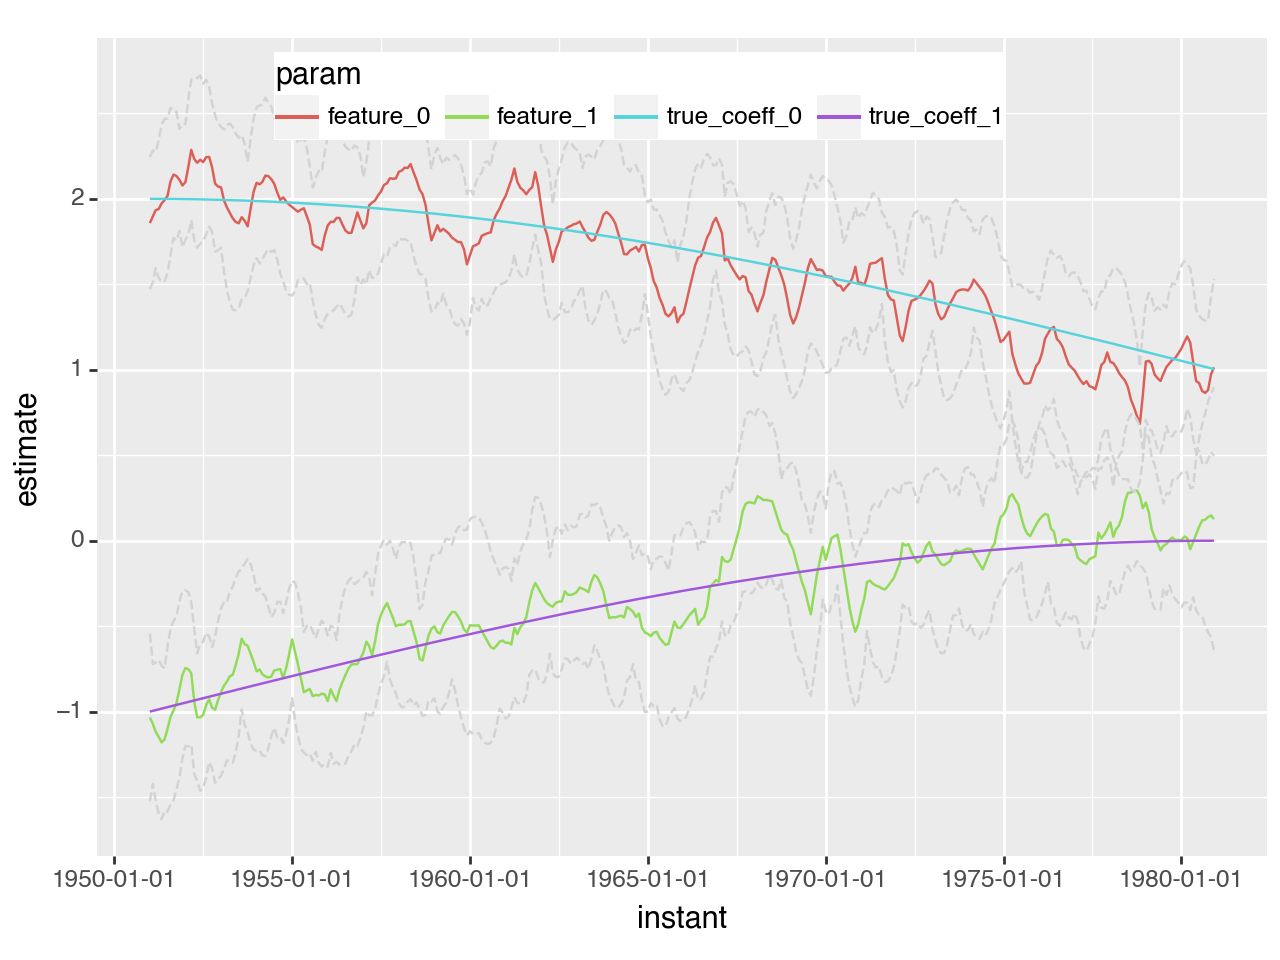

<Figure Size: (640 x 480)>

In [11]:
# Albeit noisy, the estimated regression coefficients (red and green) 
# nicely track the true values (blue and purple).

pl.timeseries_regression_coeffs(params=map_params) + true_coeff_lines

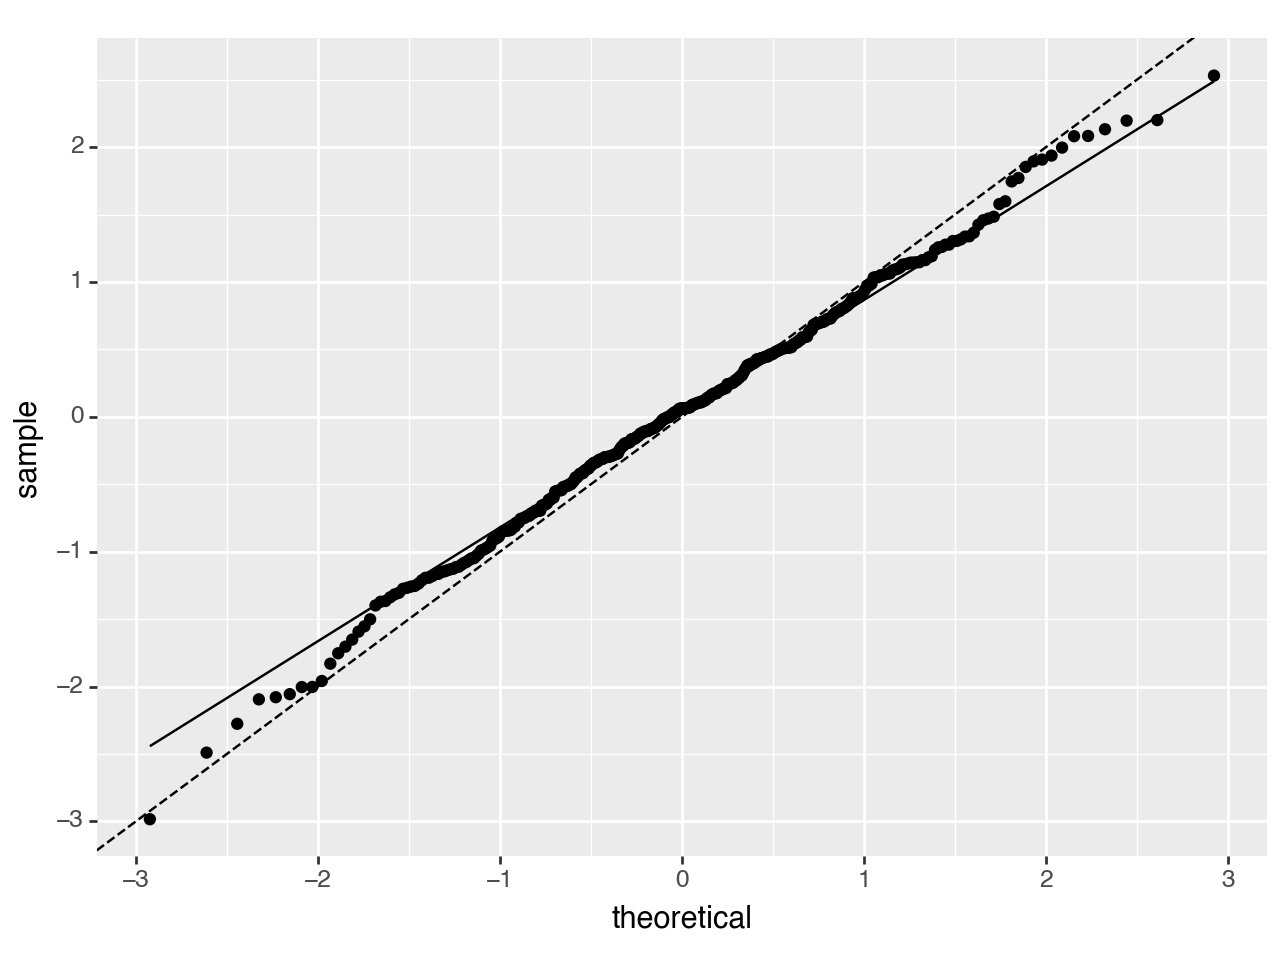

<Figure Size: (640 x 480)>

In [12]:
# Standardized residuals approximate the expected Normal(0,1) distribution.

pl.forecast_residuals_qqplot(params=map_params)

## Variational Bayes estimation

Finally, we attempt to estimate approximate posterior distributions using Variational Bayes methods.

In [13]:
vb_param_q, vb_losses = dr.fit_vb(learning_rate=0.5, num_steps=1000)

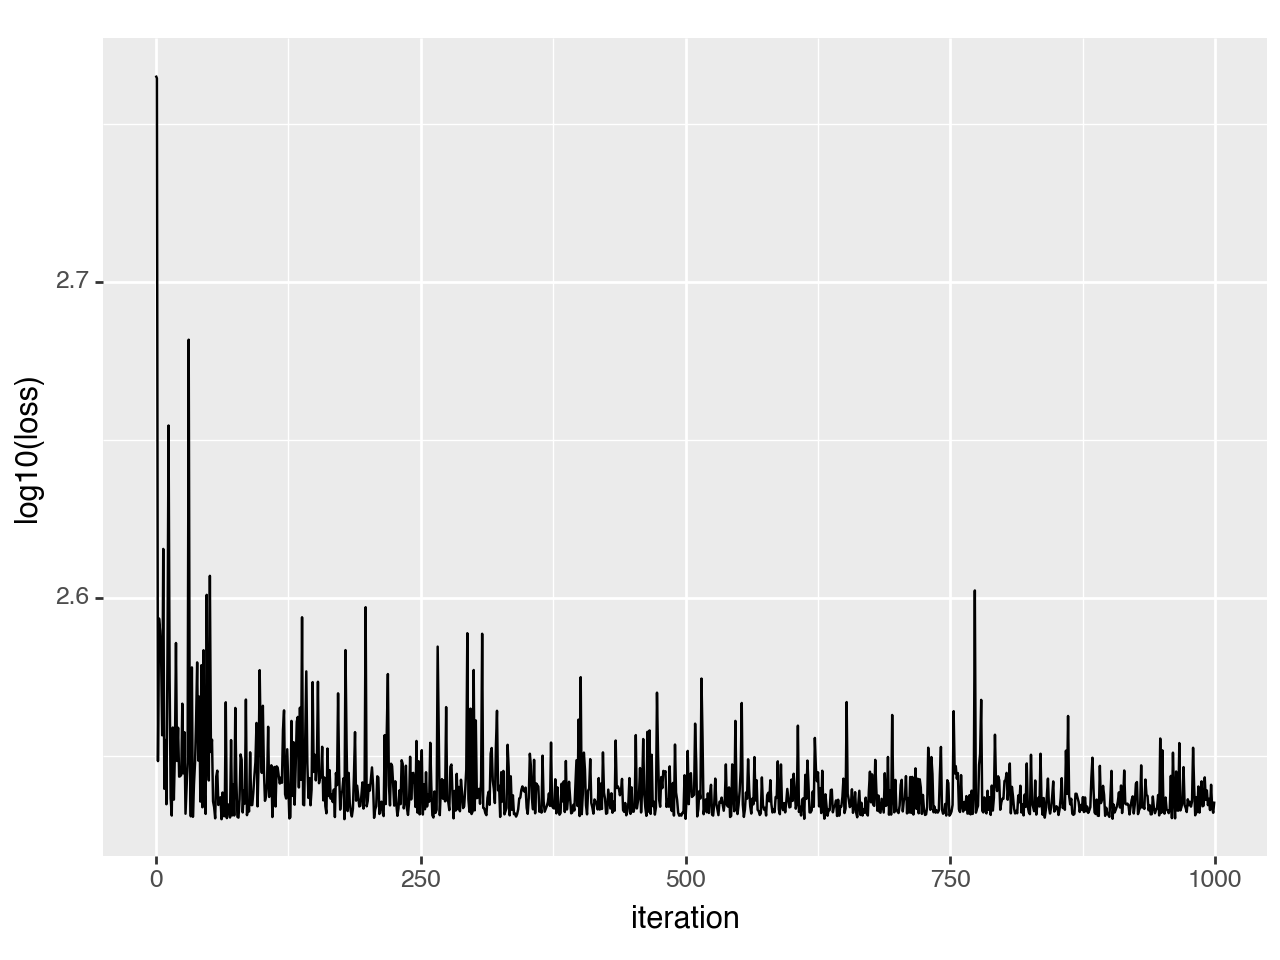

<Figure Size: (640 x 480)>

In [14]:
# plotting VB losses

pl.losses(vb_losses)

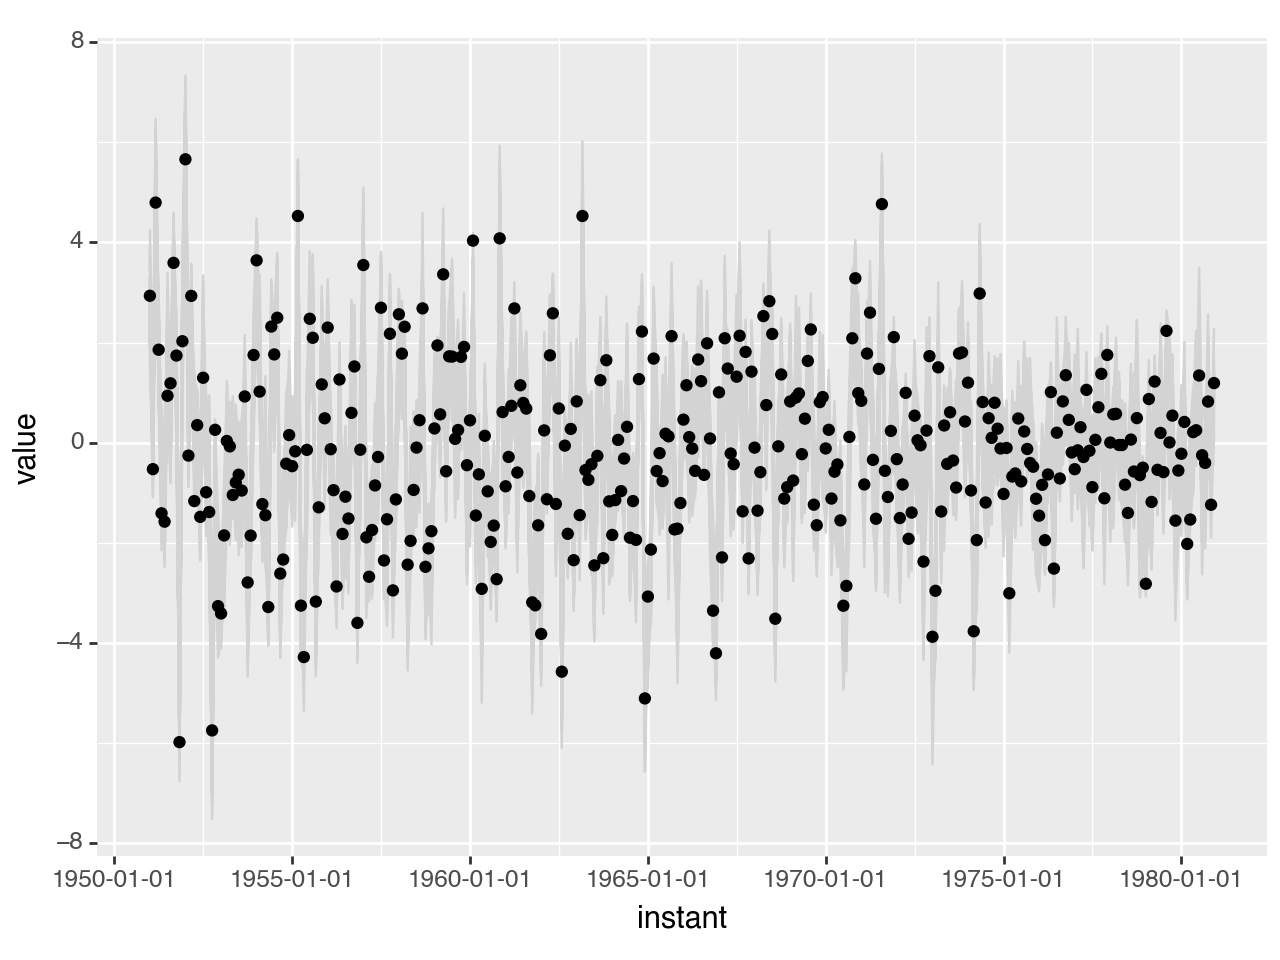

<Figure Size: (640 x 480)>

In [15]:
# Sampling from the VB prosterior and using it to plot time series of obs vs fitted

vb_params = dr.get_vb_parameter_sample(q=vb_param_q, num_samples=1)
pl.timeseries_obs_vs_fit(lines=False, points=True,
                         params=vb_params,
                         num_model_samples=60)

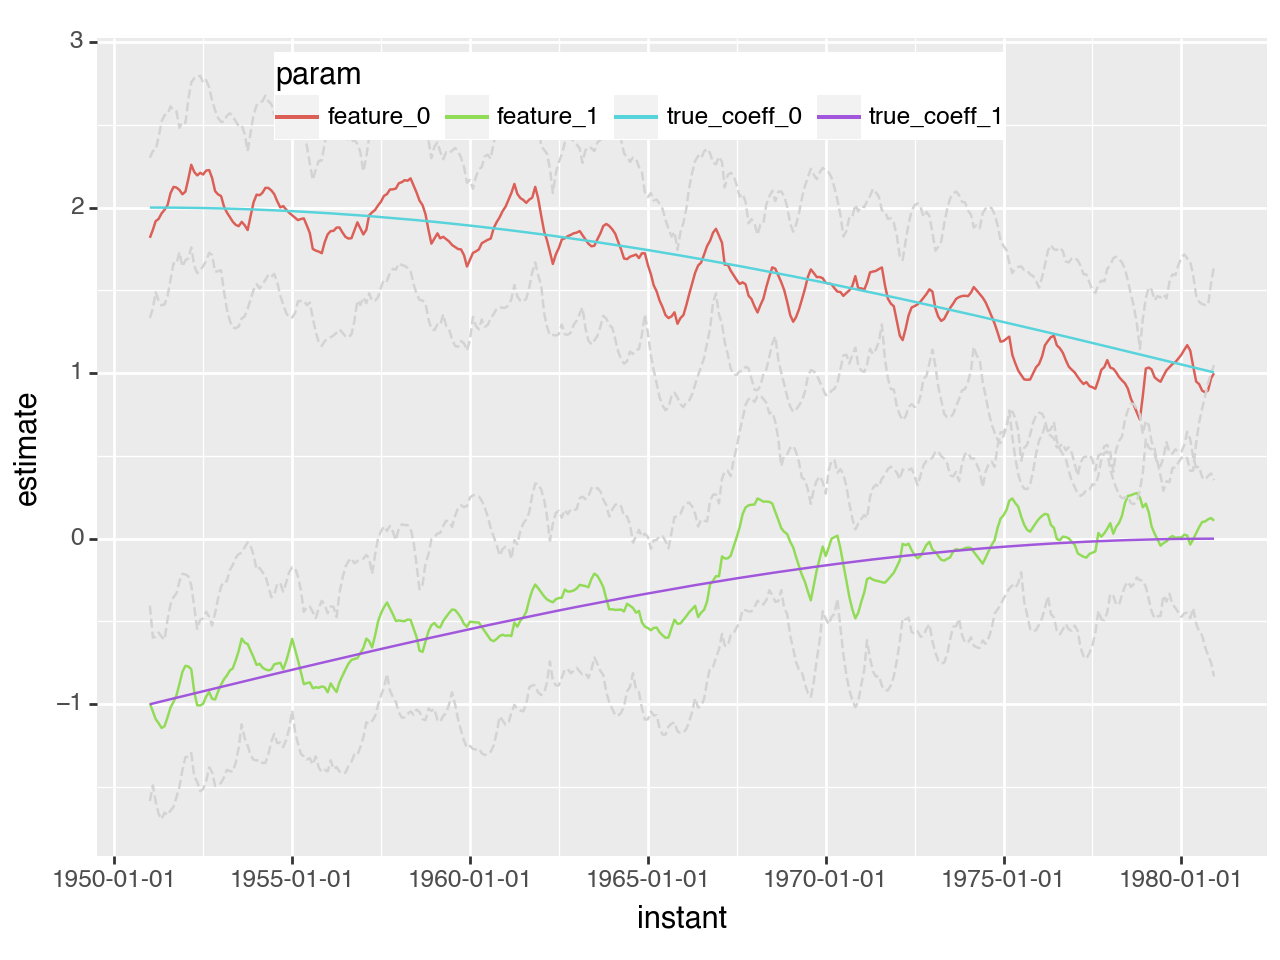

<Figure Size: (640 x 480)>

In [16]:
# As in the MAP fit, the estimated coefficients track the true coefficients. 
# The advantage of VB relative to MAP (not exploited in this notebook) is that we can account for the uncertainty 
# in our estimates of $\sigma^2$ and $\tau^2$, when building credible intervals for the regression coefficients. 
# To build the image below, we simply drew a sample from the VB posterior of these two parameters.

pl.timeseries_regression_coeffs(params=vb_params) + true_coeff_lines

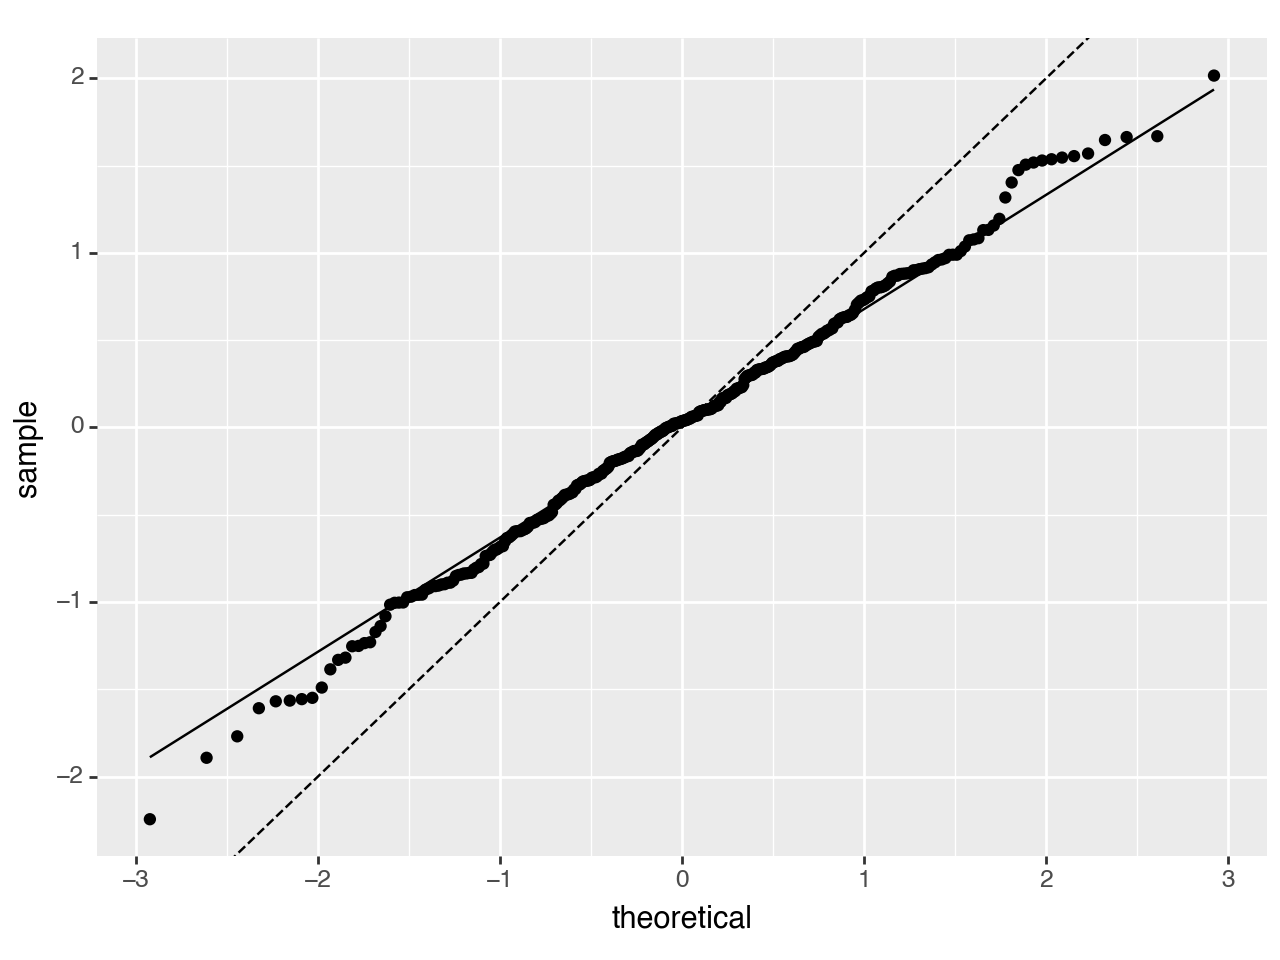

<Figure Size: (640 x 480)>

In [17]:
# QQ-plot looks good.

pl.forecast_residuals_qqplot(params=vb_params)

## Diagnostics

Here we compare the diagnostics for the 3 model runs. We'll drop the first year to allow for model burn-in.

In [18]:
diagnostics = pd.concat(
    [pd.DataFrame(dr.get_diagnostics(params=pp, time_endpoints=['1951-01', '1980-01'], model_name=nm), index=[i])
     for i, pp, nm in zip(range(3), [params, map_params, vb_params], ['no_opt', 'map', 'vb'])],
    axis=0)
diagnostics

,name,rmse,mae,bias,frac_errors_gt_2sd,crps
0,no_opt,0.710434,0.529173,0.031327,0.000000,0.610857
1,map,0.592137,0.447944,0.035471,0.040115,0.322929
2,vb,0.584763,0.441678,0.035326,0.005731,0.331848


## Conclusion

This notebook presented an example of Dynamic Linear Regression modeling. We used Tensorflow Probability to get Maximum A Posterior and Variational Bayes estimates of the unknown variance parameters and time-indexed regression coefficients. We plotted the fit, the coefficients, and the standardized forecast residuals using `plotnine`. If you want to know more about dynamic linear models, I strongly recommend the following book: 

> West, M., and Harrison, J., 1997, Bayesian Forecasting and Dynamic Models (Springer Series in Statistics).